In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score


In [2]:
train0=pd.read_csv('train.csv')
test0=pd.read_csv('test.csv')
# for call all columns and 90 rows
pd.set_option('max_columns', None)
pd.set_option('max_rows', 90)

# Cleanning


In [3]:
target = train0['SalePrice']
test_id = test0['Id']
train1 =train0.drop(['Id', 'SalePrice'], axis=1)
test1 = test0.drop('Id', axis=1)
data1 = pd.concat([train1, test1], axis=0).reset_index(drop=True)

In [4]:
data2 = data1.copy()
data2['MSSubClass']=data2['MSSubClass'].astype('str')

# Fill Categorical Features

In [5]:
#impute for a constant value
for column in ['Alley','BsmtQual','BsmtExposure', 'BsmtFinType1','BsmtCond','BsmtFinType2','FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','PoolQC', 'Fence', 'MiscFeature']:
    data2[column] = data2[column].fillna('None')
    
#impute using the column mode
for column in ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical', 'KitchenQual', 'Functional', 'SaleType']:
     data2[column] = data2[column].fillna(data2[column].mode()[0])

In [6]:
data2.select_dtypes('object').loc[:, data2.isna().sum()>0].columns

Index([], dtype='object')

In [7]:
data2.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      486
LotArea            0
Street             0
Alley              0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea        23
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         1
BsmtFinType2       0
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Heating            0
HeatingQC          0
CentralAir         0
Electrical         0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       2
BsmtHalfBath 

# Fill missing values of numerical data using knn

In [8]:
data3 = data2.copy()


In [9]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[:, numeric_df.isna().sum() == 0 ].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna()==False, na_target]
    x_train = numeric_df.loc[numeric_df[na_target].isna()==False, non_na_columns]
    x_test  = numeric_df.loc[numeric_df[na_target].isna()==True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    df.loc[df[na_target].isna()==True, na_target] = y_pred
    
    return df

In [10]:
data3.loc[:,data3.isna().sum()>0].columns

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [11]:
for column in ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea']:
    data3 = knn_impute(data3, column)

 data3.isna().sum()

In [12]:
data4 = data3.copy()

# Feature Transformation using log function

In [13]:
skew_df = pd.DataFrame(data4.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew']=skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data4[feature]))
skew_df['Absolute_skew']=skew_df['Skew'].apply(abs)
skew_df['Skewed']= skew_df['Absolute_skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute_skew,Skewed
0,LotFrontage,1.340751,1.340751,True
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,-0.599806,0.599806,True
5,YearRemodAdd,-0.451020,0.451020,False
6,MasVnrArea,2.603682,2.603682,True
7,BsmtFinSF1,1.425516,1.425516,True
8,BsmtFinSF2,4.146111,4.146111,True
9,BsmtUnfSF,0.919322,0.919322,True


In [14]:
skew_df.query('Skewed==True')['Feature']

0       LotFrontage
1           LotArea
3       OverallCond
4         YearBuilt
6        MasVnrArea
7        BsmtFinSF1
8        BsmtFinSF2
9         BsmtUnfSF
10      TotalBsmtSF
11         1stFlrSF
12         2ndFlrSF
13     LowQualFinSF
14        GrLivArea
15     BsmtFullBath
16     BsmtHalfBath
18         HalfBath
20     KitchenAbvGr
21     TotRmsAbvGrd
22       Fireplaces
26       WoodDeckSF
27      OpenPorchSF
28    EnclosedPorch
29        3SsnPorch
30      ScreenPorch
31         PoolArea
32          MiscVal
Name: Feature, dtype: object

In [15]:
for column in skew_df.query('Skewed==True')['Feature']:
    data4[column]=np.log1p(data4[column])

#  Feature Transformation using cosine function

In [16]:
data4['MoSold']=(-np.cos(0.5236*data4['MoSold']))


In [17]:
data5 = data4.copy()

# Encoding Categoricals

In [18]:
data5 = pd.get_dummies(data5)

In [19]:
data6 = data5.copy()



# Scaling

In [20]:
scaler = StandardScaler()
scaler.fit(data6)
data6 = pd.DataFrame(scaler.transform(data6), index=data6.index, columns=data6.columns)

In [21]:
data7 = data6.copy()

# Target Transformations

f:\ml\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
f:\ml\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


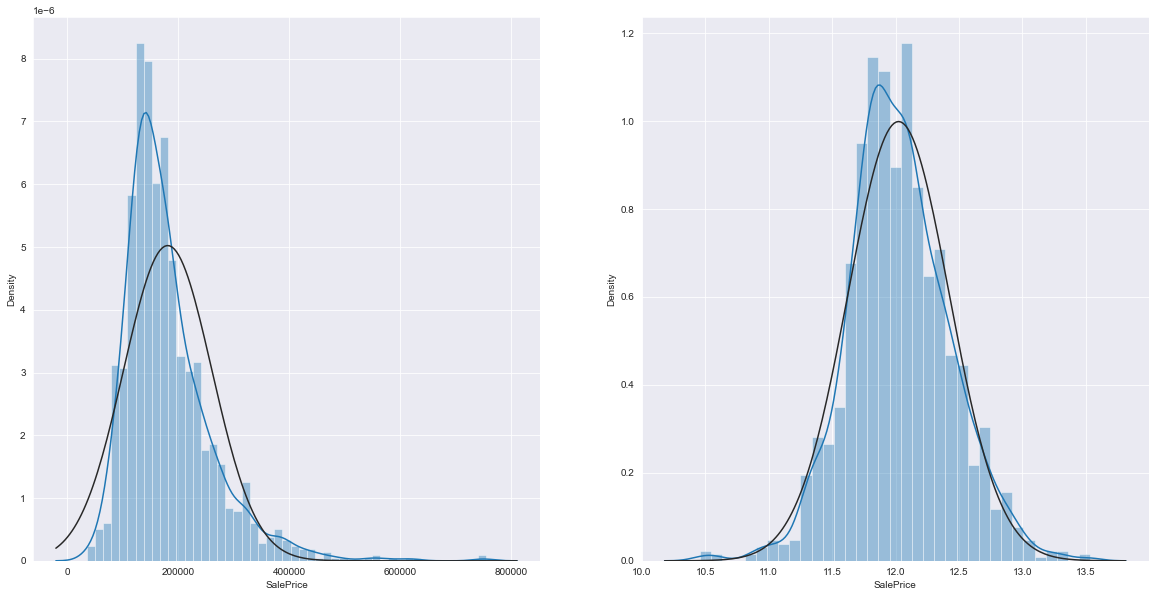

In [22]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)

plt.subplot(1,2,2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)

plt.show()

In [23]:
 logtarget = np.log(target)

# Train and Test Split

In [50]:
train_final = data7.loc[:train0.index.max(), :].copy()
test_final = data7.loc[train0.index.max()+1:, :].reset_index(drop=True).copy()

In [ ]:
After train and split we will use pycaret module to find best suitable Ml alogrithms for this problem.

In [51]:
models = {
    'br':BayesianRidge(),
    'gbr':GradientBoostingRegressor(),
    'ridge':Ridge(),
    'omp': OrthogonalMatchingPursuit(),
    'XG ': XGBRegressor()
}

for name, model in models.items():
    model.fit(train_final, logtarget)
    print(name + 'trained')

brtrained
gbrtrained
ridgetrained
omptrained
XG trained


In [52]:
results={}
kf = KFold(n_splits=10)
for name,model in models.items():
        result= np.exp(np.sqrt(-cross_val_score(model, train_final, logtarget, scoring="neg_mean_squared_error", cv=kf)))
        results[name]= result

In [53]:
results

{'br': array([1.12647591, 1.10785636, 1.12698884, 1.16898827, 1.1538688 ,
        1.14270592, 1.12838629, 1.1032448 , 1.19869609, 1.13673483]),
 'gbr': array([1.13724255, 1.1080636 , 1.12402044, 1.17919728, 1.16660995,
        1.11621835, 1.1404397 , 1.11415048, 1.12727304, 1.1512374 ]),
 'ridge': array([1.13444613, 1.11198835, 1.12859486, 1.17456205, 1.16031432,
        1.16639308, 1.13464153, 1.10353113, 1.21332879, 1.13535542]),
 'omp': array([1.12550453, 1.09788011, 1.11981216, 1.17679697, 1.1555808 ,
        1.16092027, 1.13376685, 1.10647897, 1.19143393, 1.13965602]),
 'XG ': array([1.14339352, 1.11984373, 1.13110166, 1.18915485, 1.17426636,
        1.1198134 , 1.1680487 , 1.13085396, 1.14357231, 1.15373892])}

In [54]:
for name, result in results.items():
    print(' '+name+' ')
    print(np.mean(result))
    print(np.std(result))

 br 
1.1393946115516456
0.027135661556790865
 gbr 
1.1364452793098645
0.022188402835809015
 ridge 
1.1463155664055187
0.030996592152177354
 omp 
1.1407830606340297
0.028684727647371826
 XG  
1.1473787421647712
0.022410473793708797


In [69]:
final_prediction = (
    0.35*np.exp(models['br'].predict(test_final))+
    0.35*np.exp(models['gbr'].predict(test_final))+
    0.10*np.exp(models['ridge'].predict(test_final))+
    0.20*np.exp(models['omp'].predict(test_final))
    
)
final_prediction

array([123861.1063365 , 160112.810589  , 184357.73470491, ...,
       163592.02943771, 119274.60217545, 224564.25933164])

In [70]:
submission = pd.concat([test_id, pd.Series(final_prediction, name='SalePrice')], axis=1)
submission

,Id,SalePrice
0,1461,123861.106336
1,1462,160112.810589
2,1463,184357.734705
3,1464,195466.526654
4,1465,198287.335378
...,...,...
1454,2915,83325.464386
1455,2916,83716.488470
1456,2917,163592.029438
1457,2918,119274.602175


In [71]:
submission.to_csv('s12.csv', index=False, header=True)